<a href="https://colab.research.google.com/github/ViniciusSilveiraCampos/Acoes_Previsao/blob/main/Previs%C3%A3o_Pre%C3%A7o_Das_A%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
pip install yahoo_fin

In [ ]:
# Importação para a rede neural.
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from sklearn.metrics import mean_absolute_error
torch.__version__

'2.2.1+cu121'

In [ ]:
from yahoo_fin.stock_info import get_data

In [ ]:
torch.manual_seed(123)

# Database


In [ ]:
Base = get_data('TSLA',  interval='1d')
Base.dropna()
Base.head()

,open,high,low,close,adjclose,volume,ticker
2010-06-29,1.266667,1.666667,1.169333,1.592667,1.592667,281494500,TSLA
2010-06-30,1.719333,2.028000,1.553333,1.588667,1.588667,257806500,TSLA
2010-07-01,1.666667,1.728000,1.351333,1.464000,1.464000,123282000,TSLA
2010-07-02,1.533333,1.540000,1.247333,1.280000,1.280000,77097000,TSLA
2010-07-06,1.333333,1.333333,1.055333,1.074000,1.074000,103003500,TSLA


In [ ]:
treino = Base[-50:]
Base = Base[:-50]

Base = Base.drop('ticker', axis=1)
treino = treino.drop('ticker', axis=1)

In [ ]:
base_treinamento = Base.iloc[:, 1:6].values
normalizador = MinMaxScaler(feature_range=(0, 1))
base_treinamento_normal = normalizador.fit_transform(base_treinamento)

In [ ]:
x = []
y = []

for c in range(90, len(Base)):
    x.append(base_treinamento_normal[c - 90:c, 0:5])
    y.append(base_treinamento_normal[c, 0])

x, y = np.array(x), np.array(y)

x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)
setagem_de_dados = torch.utils.data.TensorDataset(x, y)
loader = torch.utils.data.DataLoader(setagem_de_dados, batch_size=32, shuffle=True)

# Neural Network Model

In [ ]:
class regressor(nn.Module):
    def __init__(self):
        super().__init__()
        self.lsmt1 = torch.nn.LSTM(input_size=5, hidden_size=100)
        self.lsmt2 = torch.nn.LSTM(100, 250)
        self.lsmt3 = torch.nn.LSTM(250, hidden_size=50, dropout=0.3, num_layers=2)
        self.saida = torch.nn.Dropout(p=0.3)
        self.linear = torch.nn.Linear(in_features=50, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        x = x.permute(1, 0, 2)
        x, _ = self.lsmt1(x)
        x = self.saida(x)
        x, _ = self.lsmt2(x)
        x = self.saida(x)
        x, _ = self.lsmt3(x)
        x = x[-1]
        x = self.saida(x)
        x = self.linear(x)
        x = self.sigmoid(x)

        return x

In [ ]:
# Verificando a existencia da GPU.
device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
print(device)

cuda


In [ ]:
regressorzin = regressor()
criterio = nn.MSELoss()
otimizador = optim.RMSprop(regressorzin.parameters(), lr=1e-3, alpha=0.9)
regressorzin.to(device)

regressor(
  (lsmt1): LSTM(5, 100)
  (lsmt2): LSTM(100, 250)
  (lsmt3): LSTM(250, 50, num_layers=2, dropout=0.3)
  (saida): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

# Model Training


In [ ]:
# Valores da rede neural
ES_MIN_DELTA = 1e-10
ES_PATIENCE = 10
RLR_FACTOR = 0.1
RLR_PATIENCE = 5

min_loss = np.inf

In [ ]:
for epoch in range(100):
    running_loss = 0.
    running_mae = 0.

    for i, data in enumerate(loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        otimizador.zero_grad()

        outputs = regressorzin(inputs)
        outputs = outputs.flatten()

        loss = criterio(outputs, labels)
        loss.backward()

        otimizador.step()

        running_loss += loss.item()
        mae = mean_absolute_error(labels.detach().cpu().numpy().flatten(),
                                  outputs.detach().cpu().numpy().flatten())
        running_mae += mae

    running_loss /= len(loader)
    running_mae /= len(loader)

    if running_loss < min_loss:

        torch.save(regressorzin.state_dict(), 'checkpoint.pth')
        min_loss = running_loss
        es_patience = 0
        rlr_patience = 0
    else:
        if running_loss - min_loss >= ES_MIN_DELTA:
            es_patience += 1
            if es_patience == ES_PATIENCE:
                #print('--Critério de parada antecipada alcançado, parando o treinamento.')
                break

        # Reduzir a taxa de aprendizagem
        rlr_patience += 1
        if rlr_patience == RLR_PATIENCE:
            #print('--Critério de redução de taxa de aprendizagem alcançado, reduzindo LR.')
            for param_group in otimizador.param_groups:
                param_group['lr'] *= RLR_FACTOR
            rlr_patience = 0

# Neural Network Evaluation


In [ ]:
preco_real_teste = treino.iloc[:, 3:4].values
base_completa = pd.concat([Base, treino])
base_completa= base_completa.drop(base_completa.columns[0], axis=1)
entradas = base_completa[len(base_completa) - len(treino) - 90:].values
entradas = normalizador.transform(entradas)

In [ ]:
x_teste = []
for i in range(90, 141):
  x_teste.append(entradas[i-90:i,0:5])
x_teste = np.array(x_teste)
x_teste = torch.tensor(x_teste, device = device, dtype=torch.float32)

In [ ]:
regressorzin.eval()

regressor(
  (lsmt1): LSTM(5, 100)
  (lsmt2): LSTM(100, 250)
  (lsmt3): LSTM(250, 50, num_layers=2, dropout=0.3)
  (saida): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=50, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
previsoes = regressorzin(x_teste)
previsoes = previsoes.detach().cpu().numpy().reshape(-1, 1)
normalizador_previsao = MinMaxScaler(feature_range=(0, 1))
normalizador_previsao.fit(base_treinamento[:, 0:1])
previsoes = normalizador_previsao.inverse_transform(previsoes)

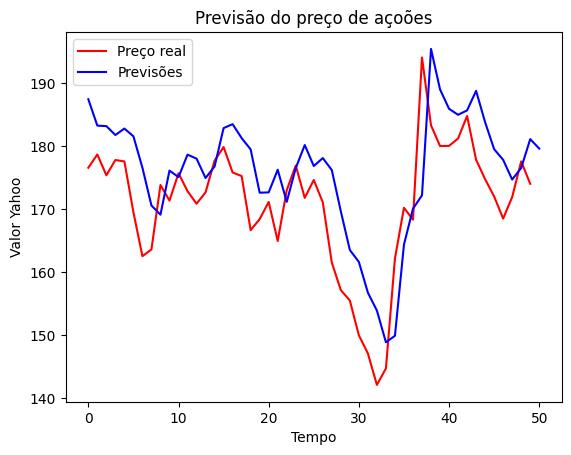

In [ ]:
plt.plot(preco_real_teste, color='red', label='Preço real')
plt.plot(previsoes, color = 'blue', label='Previsões')
plt.title('Previsão do preço de açoões')
plt.xlabel('Tempo')
plt.ylabel('Valor Yahoo')
plt.legend()